# Use NMF with Peak Shifting Learned by Gradient Decent
In our XRD measurements, the peaks shift due to temperature.
We are going to try to allow the learned components by NMF shift between different patterns
This notebook tests out our implementation written in Keras

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from multimodal.keras import SingleModalFactorization, run_training
from keras.models import Sequential
from keras.layers import InputLayer
from keras import backend as K
import numpy as np

Using TensorFlow backend.


## Some Some Synthetic Data
We want a dataset with two peaks, one that moves slightly with temperature and another that gradually increases in contribution with temperature

In [2]:
x = np.linspace(0, 10, 64)

In [3]:
def gaussian(x, b):
    return np.exp(-1 * np.power((x - b) * 2, 2))

In [4]:
signal = np.vstack([
    gaussian(x, 2+i) + i * gaussian(x, 8) for i in np.linspace(0, 1, 32)
])

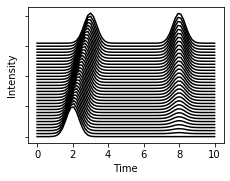

In [5]:
fig, ax = plt.subplots()

for i, row in enumerate(signal):
    ax.plot(x, row + i / 10, 'k-')

ax.set_yticklabels([])
ax.set_ylabel('Intensity')
ax.set_xlabel('Time')
fig.set_size_inches(3.5, 2.5)

As desired, we have a moving peak with constant contribution and a stationary peak that shows up in later rows

## Do Standard NMF
For a benchmark and to make sure I implemented it correctly in Keras

In [6]:
nmf = Sequential([InputLayer(batch_input_shape=signal.shape, name='signal'), SingleModalFactorization(name='factorization')])
nmf.compile('adam', 'mean_squared_error')

In [7]:
%%time
history = run_training(nmf, signal, 1000, early_stopping_patience=100)

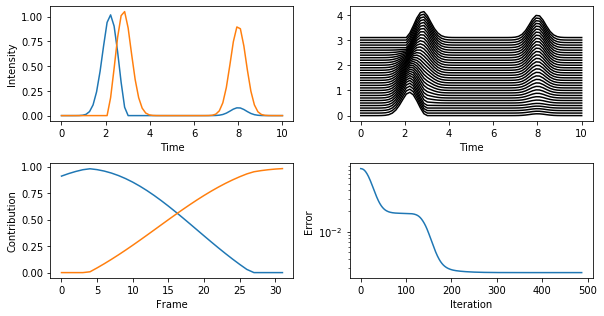

In [8]:
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()

nmf_layer = nmf.get_layer('factorization')
components = nmf_layer.get_components()
weights = nmf_layer.get_contributions()

# Plot the components
for comp in nmf_layer.get_components():
    axs[0].plot(x, comp)
axs[0].set_ylabel('Intensity')
    
# Plot the reconstruction
for i, row in enumerate(weights):
    axs[1].plot(x, np.dot(row, components) + i / 10, 'k-')
    
for ax in axs[:2]:
    ax.set_xlabel('Time')
    
for w in weights.T:
    axs[2].plot(w)
axs[2].set_xlabel('Frame')
axs[2].set_ylabel('Contribution')

axs[3].semilogy(history['epoch'], history['loss'])
axs[3].set_xlabel('Iteration')
axs[3].set_ylabel('Error')

fig.set_size_inches(8.5, 4.5)
fig.tight_layout()

*Finding*: Consistant with NMF using scikit-learn. Trains very quickly